In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
from itertools import product
from torch import tensor
import pickle
import time

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
trainset, valset = torch.utils.data.random_split(trainset, [45000, 5000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [5]:
resume = True

if resume: 
    with open('adam_big_results.pkl', 'rb') as f:
        arr = pickle.load(f)
        test_accuracy_history_adam = arr["acc"]
        test_loss_history_adam = arr["loss"]
        loss_in_training_adam= arr["loss_train"]
        time_learning_adam = arr["time"]
else:
    test_accuracy_history_adam, test_loss_history_adam, loss_in_training_adam, time_learning_adam = {}, {}, {}, {}

In [6]:
for learning_rate, weight_decay in product([0.1, 0.03, 0.01], [1e-3, 3e-4, 1e-4, 0]):
    key = (learning_rate, weight_decay)
    if key in test_accuracy_history_adam:
        print("Already computed, ignoring")
        continue
    
    lenet = torchvision.models.resnet18(pretrained=False)
    lenet.conv1 = torch.nn.Conv2d(3, 64, 3, 1, 1, bias=False)
    lenet.maxpool = torch.nn.Identity()
    lenet.cuda()
    loss = torch.nn.CrossEntropyLoss()
    
    optimizer = torch.optim.Adam(lenet.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    test_loss_history_adam[key] = list()
    test_accuracy_history_adam[key] = list()
    loss_in_training_adam[key] = list()
    time_learning_adam[key] = list()

    for epoch in range(20):
        
        sum_los = 0
        start_time = time.time()
        
        for i, data in enumerate(trainloader, 0):
            
            optimizer.zero_grad()

            X_batch, y_batch = data
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

            preds = lenet.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward()
            sum_los += float(loss_value)
            optimizer.step()
            
        time_learning_adam[key].append(time.time() - start_time)
        loss_in_training_adam[key].append(sum_los/450)
            
        correct = 0
        total = 0
        los = 0
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images, labels = images.cuda(), labels.cuda()
                outputs = lenet.forward(images)
                outputs = outputs.cuda()
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()
                loss_value = loss(outputs, labels)
                total += labels.size(0)
                los += loss_value
                
        
        test_loss_history_adam[key].append(los/50)
        print('los epoch', epoch, ':', los/50)
    
        test_accuracy_history_adam[key].append(correct/total)
        print('accuracy epoch', epoch, ':', correct/total)
    
    print(test_accuracy_history_adam[(learning_rate, weight_decay)])
    print(loss_in_training_adam[(learning_rate, weight_decay)])
    with open('adam_big_results.pkl', 'wb') as f:
        pickle.dump({"acc": test_accuracy_history_adam, "loss": test_loss_history_adam, "loss_train":loss_in_training_adam, "time":time_learning_adam}, f)

Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring


In [6]:
colors = ['r', 'b', 'g', 'k', 'm', 'c', 'y', 'orange', 'teal', 'cyan', 'purple', 'deeppink']

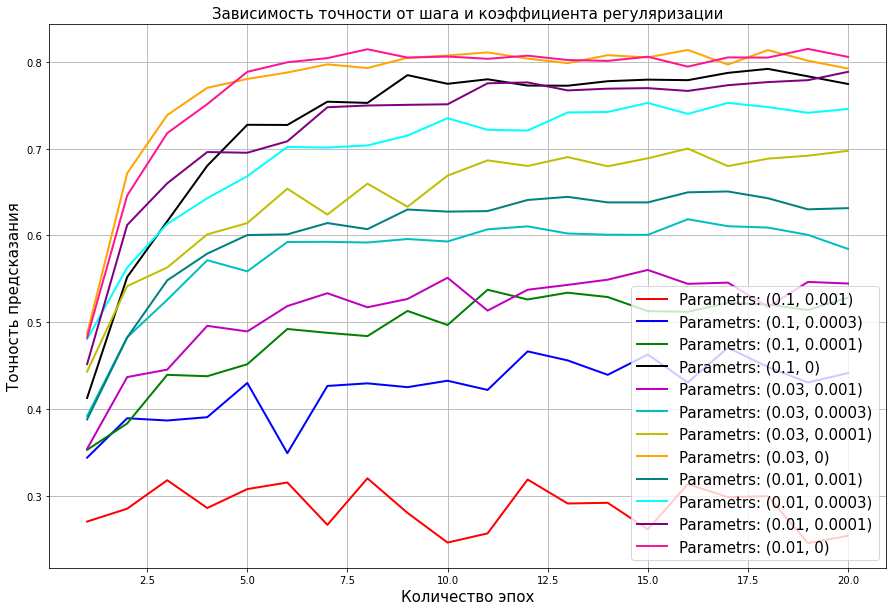

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и коэффициента регуляризации', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
j = 0
for param, accuracy in test_accuracy_history_adam.items():
    plt.plot(range(1, 21), accuracy, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)
plt.savefig('adam_2_accrucy.png')

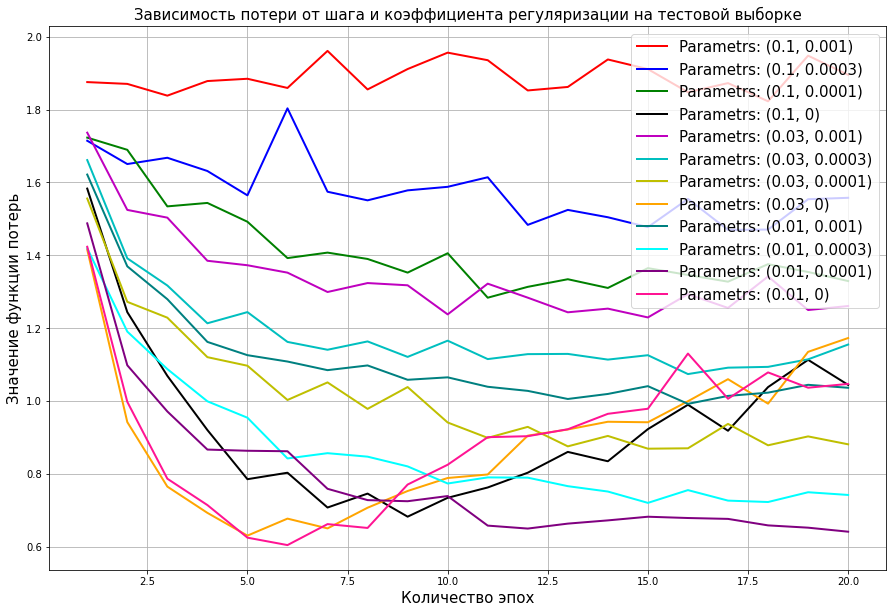

In [8]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на тестовой выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
j = 0
for param, loss in test_loss_history_adam.items():
    plt.plot(range(1, 21), list(map(lambda x: x.item(), loss)), label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j +=1
plt.legend(fontsize = 15)
plt.grid(True)
plt.savefig('adam_2_loss.png')

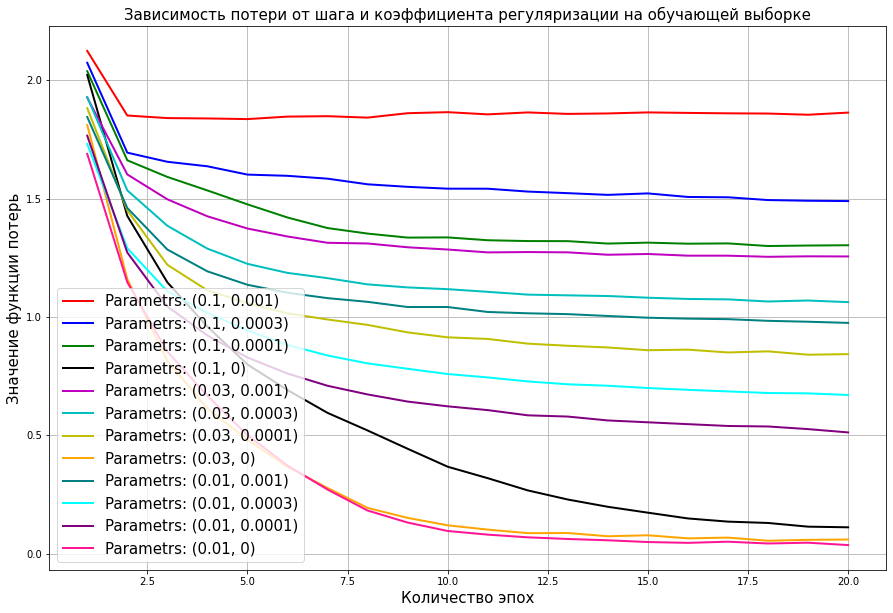

In [9]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на обучающей выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
j = 0
for param, loss in loss_in_training_adam.items():
    plt.plot(range(1, 21), loss, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)
plt.savefig('adam_2_loss_train.png')

In [19]:
time_learning_adam

{(0.1, 0.001): [37.13312911987305,
  29.859922647476196,
  30.16933512687683,
  30.191055297851562,
  30.088183641433716,
  30.15314817428589,
  30.05329704284668,
  30.21149516105652,
  30.12126922607422,
  30.148157835006714,
  30.350998878479004,
  30.355286836624146,
  30.374297857284546,
  30.294442653656006,
  30.2380690574646,
  30.286586046218872,
  30.3082914352417,
  30.351775407791138,
  30.363881587982178,
  30.338037490844727],
 (0.1, 0.0003): [30.33771538734436,
  30.17619800567627,
  30.304137229919434,
  30.25080180168152,
  30.053351402282715,
  30.130130290985107,
  30.125743627548218,
  30.136592388153076,
  30.188843965530396,
  30.074501991271973,
  30.127164602279663,
  30.135897874832153,
  30.235701322555542,
  30.09017848968506,
  30.162578105926514,
  30.22712016105652,
  30.26996350288391,
  30.228153944015503,
  30.233527421951294,
  30.24662947654724],
 (0.1, 0.0001): [30.27001714706421,
  30.2862548828125,
  30.245896816253662,
  30.08568835258484,
  30.18

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [21]:
trainset, valset = torch.utils.data.random_split(trainset, [46000, 4000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [7]:
resume = True

if resume: 
    with open('adam_results.pkl', 'rb') as f:
        arr = pickle.load(f)
        test_accuracy_history_adam = arr["acc"]
        test_loss_history_adam = arr["loss"]
        loss_in_training_adam = arr["loss_train"]
        time_learning_adam = arr["time"]
else:
    test_accuracy_history_adam, test_loss_history_adam, loss_in_training_adam, time_learning_adam = {}, {}, {}, {}

In [23]:
lenet = torchvision.models.resnet18(pretrained=False)
lenet.conv1 = torch.nn.Conv2d(3, 64, 3, 1, 1, bias=False)
lenet.maxpool = torch.nn.Identity()
lenet.cuda()
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(lenet.parameters(), lr=0.01, weight_decay=0.0001)

test_loss_history_adam = list()
test_accuracy_history_adam = list()
loss_in_training_adam = list()
time_learning_adam = list()

for epoch in range(20):

    sum_los = 0
    start_time = time.time()

    for i, data in enumerate(trainloader, 0):

        optimizer.zero_grad()

        X_batch, y_batch = data
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

        preds = lenet.forward(X_batch)

        loss_value = loss(preds, y_batch)
        loss_value.backward()
        sum_los += float(loss_value)
        optimizer.step()

    time_learning_adam.append(time.time() - start_time)
    loss_in_training_adam.append(sum_los/460)

    correct = 0
    total = 0
    los = 0
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = lenet.forward(images)
            outputs = outputs.cuda()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            loss_value = loss(outputs, labels)
            total += labels.size(0)
            los += loss_value


    test_loss_history_adam.append(los/100)
    print('los epoch', epoch, ':', los/100)

    test_accuracy_history_adam.append(correct/total)
    print('accuracy epoch', epoch, ':', correct/total)

print(test_accuracy_history_adam)
print(loss_in_training_adam)
with open('adam_results.pkl', 'wb') as f:
    pickle.dump({"acc": test_accuracy_history_adam, "loss": test_loss_history_adam, "loss_train":loss_in_training_adam, "time":time_learning_adam}, f)

los epoch 0 : tensor(1.4692, device='cuda:0')
accuracy epoch 0 : 0.4546
los epoch 1 : tensor(1.1624, device='cuda:0')
accuracy epoch 1 : 0.586
los epoch 2 : tensor(0.9846, device='cuda:0')
accuracy epoch 2 : 0.6508
los epoch 3 : tensor(0.8813, device='cuda:0')
accuracy epoch 3 : 0.6853
los epoch 4 : tensor(0.8330, device='cuda:0')
accuracy epoch 4 : 0.7074
los epoch 5 : tensor(0.7328, device='cuda:0')
accuracy epoch 5 : 0.7457
los epoch 6 : tensor(0.7600, device='cuda:0')
accuracy epoch 6 : 0.7345
los epoch 7 : tensor(0.6931, device='cuda:0')
accuracy epoch 7 : 0.7621
los epoch 8 : tensor(0.6982, device='cuda:0')
accuracy epoch 8 : 0.7546
los epoch 9 : tensor(0.7149, device='cuda:0')
accuracy epoch 9 : 0.7547
los epoch 10 : tensor(0.6919, device='cuda:0')
accuracy epoch 10 : 0.7586
los epoch 11 : tensor(0.6707, device='cuda:0')
accuracy epoch 11 : 0.7673
los epoch 12 : tensor(0.6843, device='cuda:0')
accuracy epoch 12 : 0.7654
los epoch 13 : tensor(0.6456, device='cuda:0')
accuracy epo

In [8]:
time_learning_adam

[33.342082262039185,
 30.87289261817932,
 31.009237051010132,
 31.09290599822998,
 30.989547967910767,
 31.03519558906555,
 31.07640767097473,
 30.96386480331421,
 31.145180225372314,
 30.992388486862183,
 31.04035520553589,
 31.02796769142151,
 31.06236982345581,
 31.029107809066772,
 30.974035263061523,
 31.09101915359497,
 31.0278959274292,
 31.085689544677734,
 31.084509134292603,
 31.080793380737305]

In [9]:
sum(time_learning_adam)

623.0234456062317

In [23]:
start_time = time.time()

lenet = torchvision.models.resnet18(pretrained=False)
lenet.conv1 = torch.nn.Conv2d(3, 64, 3, 1, 1, bias=False)
lenet.maxpool = torch.nn.Identity()
lenet.cuda()
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(lenet.parameters(), lr=0.01, weight_decay=0.0001)

test_loss_history_adam_res = list()
test_accuracy_history_adam_res = list()

for epoch in range(20):
    for i, data in enumerate(trainloader, 0):

        optimizer.zero_grad()

        X_batch, y_batch = data
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

        preds = lenet.forward(X_batch)

        loss_value = loss(preds, y_batch)
        loss_value.backward()
        optimizer.step()

    correct = 0
    total = 0
    los = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = lenet.forward(images)
            outputs = outputs.cuda()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            loss_value = loss(outputs, labels)
            total += labels.size(0)
            los += loss_value


    test_loss_history_adam_res.append(los/100)
    print('los epoch', epoch, ':', los/100)

    test_accuracy_history_adam_res.append(correct/total)
    print('accuracy epoch', epoch, ':', correct/total)

print(test_accuracy_history_adam_res)
with open('results.pkl', 'wb') as f:
    pickle.dump({"adam_acc": test_accuracy_history_adam_res, "adam_loss": test_loss_history_adam_res}, f)
print("--- %s seconds ---" % (time.time() - start_time))

los epoch 0 : tensor(1.3364, device='cuda:0')
accuracy epoch 0 : 0.5153
los epoch 1 : tensor(1.0377, device='cuda:0')
accuracy epoch 1 : 0.6324
los epoch 2 : tensor(0.9500, device='cuda:0')
accuracy epoch 2 : 0.6614
los epoch 4 : tensor(0.8178, device='cuda:0')
accuracy epoch 4 : 0.7089
los epoch 5 : tensor(0.7601, device='cuda:0')
accuracy epoch 5 : 0.7321
los epoch 6 : tensor(0.7419, device='cuda:0')
accuracy epoch 6 : 0.7442
los epoch 7 : tensor(0.7383, device='cuda:0')
accuracy epoch 7 : 0.7453
los epoch 8 : tensor(0.6939, device='cuda:0')
accuracy epoch 8 : 0.7602
los epoch 9 : tensor(0.6809, device='cuda:0')
accuracy epoch 9 : 0.7661
los epoch 10 : tensor(0.6609, device='cuda:0')
accuracy epoch 10 : 0.7707
los epoch 11 : tensor(0.6376, device='cuda:0')
accuracy epoch 11 : 0.7792
los epoch 12 : tensor(0.6745, device='cuda:0')
accuracy epoch 12 : 0.7669
los epoch 13 : tensor(0.6582, device='cuda:0')
accuracy epoch 13 : 0.7807
los epoch 14 : tensor(0.6308, device='cuda:0')
accuracy 